```Author: Kutsal Baran Özkurt ```

### Dependecies

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm

from confusion_mat import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from albumentations import *

from sklearn.model_selection import StratifiedKFold
from skmultilearn.model_selection import IterativeStratification

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score, roc_auc_score

from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import load_model, Model

import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


### Hyper-Parameters

In [2]:
SHAPE            = (224, 224, 3)
BATCH_SIZE       = 24
EPOCHS           = 100
N_SPLITS         = 3
SEED             = 1881
TRAIN_TEST_RATIO = 0.3

BASE_DIR = "../../"

In [3]:
metadata = pd.read_csv(os.path.join(BASE_DIR,"metadata.csv"))
metadata.head()

Patientid  offset sex   age   finding survival view  date location  \
0          2     0.0   M  65.0  COVID-19        Y   PA  2020      NaN   
1          2     3.0   M  65.0  COVID-19        Y   PA  2020      NaN   
2          2     5.0   M  65.0  COVID-19        Y   PA  2020      NaN   
3          2     6.0   M  65.0  COVID-19        Y   PA  2020      NaN   
4          4     0.0   F   NaN  COVID-19      NaN   PA  2020      NaN   

                                            filename                   doi  \
0  auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
1  auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
2  auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
3  auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
4                              nejmc2001573_f1a.jpeg                   NaN   

                                                 url license clinical notes  \
0  https://www.nejm.org/doi/full/10.1056/NEJMc200...     NaN            NaN   
1  https://www.nejm.org/doi/full/10.1056/NEJMc200...     NaN            NaN   
2  https://www.nejm.org/doi/full/10.1056/NEJMc200...     NaN            NaN   
3  https://www.nejm.org/doi/full/10.1056/NEJMc200...     NaN            NaN   
4  https://www.nejm.org/doi/full/10.1056/NEJMc200...     NaN            NaN   

  other notes  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

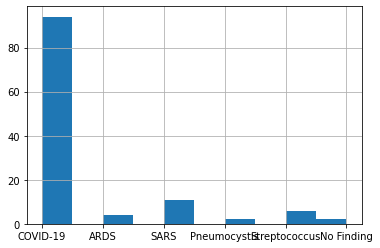

In [4]:
metadata['finding'].hist()

### Data Loader

In [5]:
class COVID19_DATASET:
    
    """
    metadata              --> pandas.DataFrame. refer -> https://github.com/ieee8023/covid-chestxray-dataset/blob/master/metadata.csv
    input_shape           --> TUPLE. Target image size
    batch_size            --> INT. Yielding data size for every iteration
    orders                --> LIST. Which images will be used. max=>len(all_images).
    base_dir              --> STR. Relative path of data directory.
    seed                  --> INT. This makes dataset generator more reproduciable 
    train_test_ratio      --> FLOAT. How much of data will be used as test set.
    augment               --> BOOL. Augment data or not.
    """
    
    def __init__(self, metadata, input_shape, batch_size, orders, base_dir, seed, train_test_ratio, augment=True):
        self.METADATA   = metadata          
        self.SHAPE      = input_shape
        self.BATCH_SIZE = batch_size
        self.arr        = orders
        self.SEED       = seed
        self.TT_RATIO   = train_test_ratio
        self.AUG        = augment
        
        self.BASE_DIR   = base_dir
        
        self.unique_labels, self.label_counts = self.get_unique_labels()
        
        self.hard_aug_probs = [0.5, 0.5, 0.7, 0.7]
        self.hard_aug_limits = [0.3,0.3,30]
        
        self.light_aug_probs = [0.5, 0.5, 0.3, 0.3]
        self.light_aug_limits = [0.1,0.1,10]
    
    def get_unique_labels(self):
        labels = []
        for f_name in os.listdir(os.path.join(self.BASE_DIR, "images")):
            get_data_row = self.METADATA[self.METADATA["filename"]==f_name]
            if not get_data_row.empty:
                labels.append(get_data_row['finding'].values)
        return np.unique(labels, return_counts=True)
    
    def get_paths_n_labels(self):
        paths = []
        y = []
        
        for f_name in os.listdir(os.path.join(self.BASE_DIR, "images")):
            get_data_row = self.METADATA[self.METADATA["filename"]==f_name]
            if not get_data_row.empty:
                # One-Hot Encoding
                label = np.zeros((len(self.unique_labels)))
                label_idx = np.where(get_data_row['finding'].values==self.unique_labels)[0][0]
                label[label_idx] = 1
                y.append(label)

                paths.append(os.path.join(self.BASE_DIR, "images", f_name))
            
        return paths, y
    
    def __len__(self):
        return len(self.get_paths_n_labels()[0])
    
    def augmenting(self, img, aug_probs, aug_limits):
        if self.AUG:
            augment = Compose([HorizontalFlip(p=aug_probs[0]),
                               CLAHE(p=aug_probs[1]),
                               RandomBrightnessContrast(p=aug_probs[2]),
                               ShiftScaleRotate(p=aug_probs[3], shift_limit=aug_limits[0], scale_limit=aug_limits[1], rotate_limit=aug_limits[2])])  
        else:
            augment = Compose([])  

        img = augment(image=img)['image']
        return img
    
    def get_shuffled_data(self):
        img_paths, labels = self.get_paths_n_labels()

        np.random.seed(self.SEED) 
        np.random.shuffle(img_paths)
        
        np.random.seed(self.SEED) 
        np.random.shuffle(labels)
        
        return img_paths, labels
        
    def split_train_test(self, get):  # get=={"train","test"}
        img_paths, labels = self.get_shuffled_data()
        x_train, y_train, x_test, y_test = self.iterative_train_test_split(np.array(img_paths), np.array(labels), test_size=self.TT_RATIO)
        
        if get=='train':
            return x_train, y_train
        
        elif get=='test':
            return x_test, y_test
        
    def iterative_train_test_split(self, X, y, test_size):
        """Iteratively stratified train/test split
        Parameters
        ----------
        test_size : float, [0,1]
            the proportion of the dataset to include in the test split, the rest will be put in the train set
        Returns
        -------
        X_train, y_train, X_test, y_test
            stratified division into train/test split
        """

        stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size])
        train_indexes, test_indexes = next(stratifier.split(y, y))
        
        X_train, y_train = X[train_indexes], y[train_indexes]
        X_test, y_test = X[test_indexes], y[test_indexes]

        return X_train, y_train, X_test, y_test

    def data_generator(self):
        img_paths, labels = self.split_train_test(get="train")
        
        while True:
            x_batch = np.empty((self.BATCH_SIZE,)+self.SHAPE, dtype=np.float32)
            y_batch = np.empty((self.BATCH_SIZE, len(self.unique_labels)), dtype=np.float32)

            batch = np.random.choice(self.arr, self.BATCH_SIZE)

            for ix, id_ in enumerate(batch):
                
                # y 
                label = labels[id_]
                
                # x
                img_path = img_paths[id_]
                img = cv2.imread(img_path)
                
                if not np.squeeze(np.where(self.unique_labels=='COVID-19'))==np.squeeze(np.where(label==max(label))):
                    img = self.augmenting(img, self.hard_aug_probs, self.hard_aug_limits)
                else:
                    img = self.augmenting(img, self.light_aug_probs, self.light_aug_limits)
                
                img = cv2.resize(img, self.SHAPE[:2])
                img = np.divide(img,255)

                # Store the values    
                x_batch[ix] = img
                y_batch[ix] = label

            yield x_batch, y_batch

[[[0.02352941 0.02745098 0.02745098]
  [0.02352941 0.02745098 0.02745098]
  [0.02352941 0.02745098 0.02745098]
  ...
  [0.02352941 0.02745098 0.02745098]
  [0.02352941 0.02745098 0.02745098]
  [0.02352941 0.02745098 0.02745098]]

 [[0.02352941 0.02745098 0.02745098]
  [0.02352941 0.02745098 0.02745098]
  [0.02352941 0.02745098 0.02745098]
  ...
  [0.02352941 0.02745098 0.02745098]
  [0.02352941 0.02745098 0.02745098]
  [0.02352941 0.02745098 0.02745098]]

 [[0.02352941 0.02745098 0.02745098]
  [0.02352941 0.02745098 0.02745098]
  [0.02352941 0.02745098 0.02745098]
  ...
  [0.02352941 0.02745098 0.02745098]
  [0.02352941 0.02745098 0.02745098]
  [0.02352941 0.02745098 0.02745098]]

 ...

 [[0.40392157 0.40392157 0.40392157]
  [0.37254903 0.37254903 0.37254903]
  [0.38039216 0.38039216 0.38039216]
  ...
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]]

 [[0.35686275 0.35686275 0.35686275]
  [0.3882353  0.3882353  0.3882353 ]


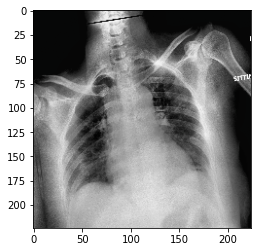

In [6]:
sample_dataset = COVID19_DATASET(metadata, SHAPE, BATCH_SIZE, range(1), BASE_DIR, SEED, TRAIN_TEST_RATIO, augment=True)

for ix, data in enumerate(sample_dataset.data_generator()):
    img_batch, label_batch = data
    print(img_batch[0])
    print(img_batch[0].shape)
    print("-"*10)
    print(label_batch[0])
    print(label_batch[0].shape)
    print("-"*10)
    plt.imshow(img_batch[0])
    plt.show()
    
    if ix==0:
        break

### Metrics

In [7]:
# credits: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def recall(y_true, y_pred):
    """
    Recall metric.
    
    Only computes a batch-wise average of recall.
    
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    
    Only computes a batch-wise average of precision.
    
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    return 2*((precisionx*recallx)/(precisionx+recallx+K.epsilon()))

### Learning Rate Scheduler

In [8]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

## BreastNet

### Citation
```
M. Togaçar, K.B. Özkurt, B. Ergen et al., BreastNet: A novel ˘
convolutional neural network model through histopathological images for the diagnosis of breast
cancer, Physica A (2019), doi: https://doi.org/10.1016/j.physa.2019.123592.
```

In [9]:
# copied from https://github.com/kobiso/CBAM-keras/blob/master/models/attention_module.py
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature._keras_shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature._keras_shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature._keras_shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool._keras_shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool._keras_shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat._keras_shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature._keras_shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

In [10]:
# copied from https://gist.github.com/mjdietzx/5319e42637ed7ef095d430cb5c5e8c64
def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y

In [11]:
def create_model(out_neuron_number):
    
    dropRate = 0.3
    
    init = Input(SHAPE)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 64)
    x2 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(out_neuron_number, activation='softmax')(x)
   
    model = Model(init, y)
    return model

In [12]:
model = create_model(len(sample_dataset.unique_labels))
model.summary()

W0316 14:41:27.311947 19208 module_wrapper.py:139] From C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0316 14:41:27.313949 19208 module_wrapper.py:139] From C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0316 14:41:27.315947 19208 module_wrapper.py:139] From C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0316 14:41:27.332947 19208 module_wrapper.py:139] From C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0316 14:41:27.3

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

global_average_pooling2d_2 (Glo (None, 128)          0           activation_5[0][0]               
__________________________________________________________________________________________________
global_max_pooling2d_2 (GlobalM (None, 128)          0           activation_5[0][0]               
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 1, 1, 128)    0           global_average_pooling2d_2[0][0] 
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 1, 1, 128)    0           global_max_pooling2d_2[0][0]     
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1, 1, 16)     2064        reshape_3[0][0]                  
                                                                 reshape_4[0][0]                  
__________

### Training

In [13]:
skf = StratifiedKFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)
x_t, y_t = sample_dataset.split_train_test("train")
for ix, (train_index, val_index) in enumerate(skf.split(x_t, y_t.argmax(1))):
                                               
    tg = COVID19_DATASET(metadata, SHAPE, BATCH_SIZE, train_index, BASE_DIR, SEED, TRAIN_TEST_RATIO, augment=True)
    vg = COVID19_DATASET(metadata, SHAPE, BATCH_SIZE, val_index  , BASE_DIR, SEED, TRAIN_TEST_RATIO, augment=False)
        
    schedule = SGDRScheduler(min_lr=1e-6,
                             max_lr=1e-3,
                             steps_per_epoch=np.ceil(EPOCHS/BATCH_SIZE),
                             lr_decay=0.9,
                             cycle_length=10,
                             mult_factor=2.)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=[precision, recall, f1, 'acc'])
    
    if not os.path.exists("models"):
        os.makedirs("models")
        
    model_ckpt = "models/BREASTNET_COVID19_FOLD_"+str(ix)+".h5"
    callbacks = [ModelCheckpoint(model_ckpt, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False),
                 TensorBoard(log_dir='./t_logs/log_'+str(ix), update_freq='batch'), 
                 schedule] 
    
    
    model.fit_generator(tg.data_generator(),
                        steps_per_epoch=len(train_index),
                        epochs=EPOCHS,
                        verbose=2,
                        validation_data=vg.data_generator(),
                        validation_steps=len(val_index)//BATCH_SIZE if len(val_index)//BATCH_SIZE else 1,
                        callbacks=callbacks)


W0316 06:28:27.166211  6724 module_wrapper.py:139] From C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0316 06:28:27.171256  6724 module_wrapper.py:139] From C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0316 06:28:27.747553  6724 deprecation.py:323] From C:\Users\pc\Anaconda3\envs\dl\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0316 06:28:28.280450  6724 module_wrapper.py:139] From C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.

Epoch 1/100


W0316 06:28:36.921128  6724 module_wrapper.py:139] From C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\keras\callbacks.py:995: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.



 - 98s - loss: 0.7367 - precision: 0.8166 - recall: 0.6929 - f1: 0.7287 - acc: 0.7778 - val_loss: 0.6850 - val_precision: 0.9375 - val_recall: 0.6250 - val_f1: 0.7500 - val_acc: 0.9167

Epoch 00001: val_loss improved from inf to 0.68504, saving model to models/BREASTNET_COVID19_FOLD_0.h5
Epoch 2/100
 - 95s - loss: 0.5675 - precision: 0.8426 - recall: 0.8140 - f1: 0.8278 - acc: 0.8295 - val_loss: 2.9127 - val_precision: 0.4348 - val_recall: 0.4167 - val_f1: 0.4255 - val_acc: 0.4167

Epoch 00002: val_loss did not improve from 0.68504
Epoch 3/100
 - 98s - loss: 0.5130 - precision: 0.8547 - recall: 0.8194 - f1: 0.8364 - acc: 0.8418 - val_loss: 1.0496 - val_precision: 0.6818 - val_recall: 0.6250 - val_f1: 0.6522 - val_acc: 0.7083

Epoch 00003: val_loss did not improve from 0.68504
Epoch 4/100
 - 91s - loss: 0.4542 - precision: 0.8746 - recall: 0.8318 - f1: 0.8521 - acc: 0.8519 - val_loss: 0.6574 - val_precision: 0.8696 - val_recall: 0.8333 - val_f1: 0.8511 - val_acc: 0.8333

Epoch 00004: va


Epoch 00065: val_loss did not improve from 0.19472
Epoch 66/100
 - 98s - loss: 0.0517 - precision: 0.9868 - recall: 0.9838 - f1: 0.9853 - acc: 0.9853 - val_loss: 0.9148 - val_precision: 0.8333 - val_recall: 0.8333 - val_f1: 0.8333 - val_acc: 0.8333

Epoch 00066: val_loss did not improve from 0.19472
Epoch 67/100
 - 94s - loss: 0.0755 - precision: 0.9814 - recall: 0.9792 - f1: 0.9803 - acc: 0.9807 - val_loss: 2.2968 - val_precision: 0.7917 - val_recall: 0.7917 - val_f1: 0.7917 - val_acc: 0.7917

Epoch 00067: val_loss did not improve from 0.19472
Epoch 68/100
 - 94s - loss: 0.1034 - precision: 0.9705 - recall: 0.9637 - f1: 0.9670 - acc: 0.9676 - val_loss: 2.7977 - val_precision: 0.8333 - val_recall: 0.8333 - val_f1: 0.8333 - val_acc: 0.8333

Epoch 00068: val_loss did not improve from 0.19472
Epoch 69/100
 - 92s - loss: 0.0950 - precision: 0.9733 - recall: 0.9637 - f1: 0.9684 - acc: 0.9691 - val_loss: 0.2295 - val_precision: 0.8750 - val_recall: 0.8750 - val_f1: 0.8750 - val_acc: 0.8750



Epoch 00098: val_loss did not improve from 0.12302
Epoch 99/100
 - 97s - loss: 0.0487 - precision: 0.9869 - recall: 0.9838 - f1: 0.9853 - acc: 0.9846 - val_loss: 2.5556 - val_precision: 0.5833 - val_recall: 0.5833 - val_f1: 0.5833 - val_acc: 0.5833

Epoch 00099: val_loss did not improve from 0.12302
Epoch 100/100
 - 99s - loss: 0.0674 - precision: 0.9791 - recall: 0.9738 - f1: 0.9764 - acc: 0.9761 - val_loss: 9.5263 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_acc: 0.0000e+00

Epoch 00100: val_loss did not improve from 0.12302
Epoch 1/100
 - 84s - loss: 0.3130 - precision: 0.9137 - recall: 0.8935 - f1: 0.9033 - acc: 0.9005 - val_loss: 1.1798 - val_precision: 0.8333 - val_recall: 0.8333 - val_f1: 0.8333 - val_acc: 0.8333

Epoch 00001: val_loss improved from inf to 1.17983, saving model to models/BREASTNET_COVID19_FOLD_1.h5
Epoch 2/100
 - 85s - loss: 0.1951 - precision: 0.9426 - recall: 0.9213 - f1: 0.9316 - acc: 0.9298 - val_loss: 0.1710 - val_precisi


Epoch 00063: val_loss did not improve from 0.00049
Epoch 64/100
 - 91s - loss: 0.0217 - precision: 0.9946 - recall: 0.9915 - f1: 0.9930 - acc: 0.9931 - val_loss: 0.0335 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000 - val_acc: 1.0000

Epoch 00064: val_loss did not improve from 0.00049
Epoch 65/100
 - 90s - loss: 0.0250 - precision: 0.9938 - recall: 0.9938 - f1: 0.9938 - acc: 0.9938 - val_loss: 1.7379 - val_precision: 0.7500 - val_recall: 0.7500 - val_f1: 0.7500 - val_acc: 0.7500

Epoch 00065: val_loss did not improve from 0.00049
Epoch 66/100
 - 89s - loss: 0.0262 - precision: 0.9938 - recall: 0.9915 - f1: 0.9926 - acc: 0.9931 - val_loss: 0.0441 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000 - val_acc: 1.0000

Epoch 00066: val_loss did not improve from 0.00049
Epoch 67/100
 - 89s - loss: 0.0293 - precision: 0.9946 - recall: 0.9900 - f1: 0.9922 - acc: 0.9900 - val_loss: 0.8470 - val_precision: 0.8750 - val_recall: 0.8750 - val_f1: 0.8750 - val_acc: 0.8750



Epoch 00096: val_loss did not improve from 0.00049
Epoch 97/100
 - 87s - loss: 0.0352 - precision: 0.9907 - recall: 0.9869 - f1: 0.9888 - acc: 0.9869 - val_loss: 1.2182 - val_precision: 0.9167 - val_recall: 0.9167 - val_f1: 0.9167 - val_acc: 0.9167

Epoch 00097: val_loss did not improve from 0.00049
Epoch 98/100
 - 86s - loss: 0.0535 - precision: 0.9838 - recall: 0.9823 - f1: 0.9830 - acc: 0.9830 - val_loss: 1.2692 - val_precision: 0.7500 - val_recall: 0.7500 - val_f1: 0.7500 - val_acc: 0.7500

Epoch 00098: val_loss did not improve from 0.00049
Epoch 99/100
 - 86s - loss: 0.0302 - precision: 0.9892 - recall: 0.9861 - f1: 0.9876 - acc: 0.9869 - val_loss: 0.5448 - val_precision: 0.9583 - val_recall: 0.9583 - val_f1: 0.9583 - val_acc: 0.9583

Epoch 00099: val_loss did not improve from 0.00049
Epoch 100/100
 - 87s - loss: 0.0313 - precision: 0.9907 - recall: 0.9892 - f1: 0.9900 - acc: 0.9900 - val_loss: 0.9223 - val_precision: 0.8333 - val_recall: 0.8333 - val_f1: 0.8333 - val_acc: 0.8333


Epoch 00028: val_loss did not improve from 0.00791
Epoch 29/100
 - 90s - loss: 0.0598 - precision: 0.9814 - recall: 0.9792 - f1: 0.9803 - acc: 0.9792 - val_loss: 0.2530 - val_precision: 0.9167 - val_recall: 0.9167 - val_f1: 0.9167 - val_acc: 0.9167

Epoch 00029: val_loss did not improve from 0.00791
Epoch 30/100
 - 90s - loss: 0.0363 - precision: 0.9903 - recall: 0.9851 - f1: 0.9876 - acc: 0.9888 - val_loss: 1.3303 - val_precision: 0.9167 - val_recall: 0.9167 - val_f1: 0.9167 - val_acc: 0.9167

Epoch 00030: val_loss did not improve from 0.00791
Epoch 31/100
 - 91s - loss: 0.0451 - precision: 0.9866 - recall: 0.9836 - f1: 0.9851 - acc: 0.9844 - val_loss: 0.1790 - val_precision: 1.0000 - val_recall: 0.9167 - val_f1: 0.9565 - val_acc: 0.9167

Epoch 00031: val_loss did not improve from 0.00791
Epoch 32/100
 - 92s - loss: 0.0642 - precision: 0.9858 - recall: 0.9821 - f1: 0.9839 - acc: 0.9821 - val_loss: 1.1309 - val_precision: 0.6250 - val_recall: 0.6250 - val_f1: 0.6250 - val_acc: 0.6250



Epoch 00061: val_loss did not improve from 0.00699
Epoch 62/100
 - 96s - loss: 0.0177 - precision: 0.9940 - recall: 0.9933 - f1: 0.9937 - acc: 0.9933 - val_loss: 0.9189 - val_precision: 0.9167 - val_recall: 0.9167 - val_f1: 0.9167 - val_acc: 0.9167

Epoch 00062: val_loss did not improve from 0.00699
Epoch 63/100
 - 90s - loss: 0.0299 - precision: 0.9926 - recall: 0.9911 - f1: 0.9918 - acc: 0.9918 - val_loss: 0.4724 - val_precision: 0.9583 - val_recall: 0.9583 - val_f1: 0.9583 - val_acc: 0.9583

Epoch 00063: val_loss did not improve from 0.00699
Epoch 64/100
 - 91s - loss: 0.0207 - precision: 0.9948 - recall: 0.9933 - f1: 0.9940 - acc: 0.9940 - val_loss: 0.0205 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000 - val_acc: 1.0000

Epoch 00064: val_loss did not improve from 0.00699
Epoch 65/100
 - 88s - loss: 0.0158 - precision: 0.9970 - recall: 0.9963 - f1: 0.9966 - acc: 0.9970 - val_loss: 0.6717 - val_precision: 0.8333 - val_recall: 0.8333 - val_f1: 0.8333 - val_acc: 0.8333



Epoch 00094: val_loss did not improve from 0.00699
Epoch 95/100
 - 90s - loss: 0.0071 - precision: 1.0000 - recall: 0.9993 - f1: 0.9996 - acc: 0.9993 - val_loss: 1.0685 - val_precision: 0.7917 - val_recall: 0.7917 - val_f1: 0.7917 - val_acc: 0.7917

Epoch 00095: val_loss did not improve from 0.00699
Epoch 96/100
 - 92s - loss: 0.0181 - precision: 0.9933 - recall: 0.9926 - f1: 0.9929 - acc: 0.9926 - val_loss: 0.8812 - val_precision: 0.8750 - val_recall: 0.8750 - val_f1: 0.8750 - val_acc: 0.8750

Epoch 00096: val_loss did not improve from 0.00699
Epoch 97/100
 - 92s - loss: 0.0292 - precision: 0.9926 - recall: 0.9926 - f1: 0.9926 - acc: 0.9926 - val_loss: 1.1954 - val_precision: 0.8261 - val_recall: 0.7917 - val_f1: 0.8085 - val_acc: 0.7917

Epoch 00097: val_loss did not improve from 0.00699
Epoch 98/100
 - 87s - loss: 0.0386 - precision: 0.9866 - recall: 0.9836 - f1: 0.9851 - acc: 0.9851 - val_loss: 0.6226 - val_precision: 0.8750 - val_recall: 0.8750 - val_f1: 0.8750 - val_acc: 0.8750


### Testing

In [14]:
gen = COVID19_DATASET(metadata, SHAPE, BATCH_SIZE, range(1), BASE_DIR, SEED, TRAIN_TEST_RATIO, augment=False).split_train_test("test")
                       
x_test = np.zeros((len(gen[0]),)+SHAPE, dtype=np.float32)
y_test = np.zeros((len(gen[1]), len(sample_dataset.unique_labels)), dtype=np.float32)

for ix, path in tqdm(enumerate(gen[0])):
    img = cv2.imread(path)
    img = cv2.resize(img, SHAPE[:2])
    img = np.divide(img,255)

    label = gen[1][ix]

    x_test[ix] = img
    y_test[ix] = label

36it [00:01, 34.47it/s]


In [15]:
# Threshold predictions with THRESH_VAL
def threshold_arr(array):
    # Get all value from array
    # Compare calue with THRESH_VAL 
    # IF value >= THRESH_VAL. round to 1
    # ELSE. round to 0
    new_arr = []
    for ix, val in enumerate(array):
        loc = np.array(val).argmax(axis=0)
        k = list(np.zeros((len(val)), dtype=np.float32))
        k[loc]=1
        new_arr.append(k)
        
    return np.array(new_arr, dtype=np.float32)

### Get Results

In [16]:
models = []
scores = []
for i in range(N_SPLITS):
    model = load_model("models/BREASTNET_COVID19_FOLD_{}.h5".format(i), custom_objects={'f1': f1, 'precision': precision, 'recall': recall})
    score = model.evaluate(x_test, y_test, verbose=0)
    print(score)
    scores.append(score[-1])
    models.append(model)

W0316 14:41:44.059517 19208 module_wrapper.py:139] From C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0316 14:41:44.064520 19208 module_wrapper.py:139] From C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0316 14:41:44.151547 19208 deprecation.py:323] From C:\Users\pc\Anaconda3\envs\dl\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0316 14:41:44.687548 19208 module_wrapper.py:139] From C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.

[1.324776440858841, 0.8333333333333334, 0.8333333333333334, 0.8333332737286886, 0.8333333333333334]
[1.653943591647678, 0.8611111111111112, 0.8611111111111112, 0.8611110515064664, 0.8611111111111112]
[1.162466337852594, 0.7706093258327908, 0.75, 0.7601410547892252, 0.7777777777777778]


In [17]:
best_model_idx = np.array(scores).argmax()
best_model = models[best_model_idx]
print(best_model_idx)

1


In [18]:
y_preds = threshold_arr(best_model.predict(x_test, verbose=0))

ROC_AUC: 0.9166666666666666, Accuracy: 0.8611111111111112, F1_Score: 0.8611111111111112, Precision: 0.8611111111111112, Recall: 0.8611111111111112


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.85      1.00      0.92        28
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         3
           5       0.00      0.00      0.00         2

   micro avg       0.86      0.86      0.86        36
   macro avg       0.31      0.33      0.32        36
weighted avg       0.74      0.86      0.80        36
 samples avg       0.86      0.86      0.86        36





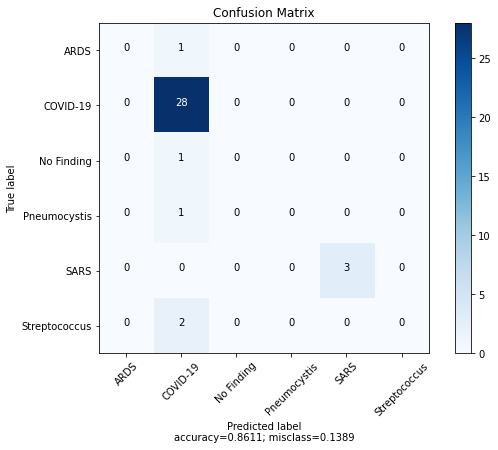

In [19]:
results = precision_recall_fscore_support(y_test, y_preds, average='micro')
acc = accuracy_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_preds, average='micro')

print("ROC_AUC: {}, Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(roc_auc, acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(y_test, y_preds))
print("\n")
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_preds.argmax(axis=1))

plot_confusion_matrix(cm           = cnf_matrix, 
                      desc         = f"{best_model_idx+1}. FOLD (BEST) - Multiclass",
                      normalize    = False,
                      target_names = sample_dataset.unique_labels,
                      title        = "Confusion Matrix")

### BREASTNET-COVID-19 Convert Predictions to Binary Classification (COVID-19 or NOT)

In [20]:
covid_ord = np.where(sample_dataset.unique_labels=='COVID-19')[0][0]

In [21]:
bin_labels = []
for pred in y_test:
    if pred.argmax() == covid_ord:
        binary_label = 1
    else:
        binary_label = 0
    bin_labels.append(binary_label)
    
bin_preds = []
for pred in y_preds:
    if pred.argmax() == covid_ord:
        binary_label = 1
    else:
        binary_label = 0
    bin_preds.append(binary_label)

ROC_AUC: 0.6875, Accuracy: 0.8611111111111112, F1_Score: 0.9180327868852458, Precision: 0.8484848484848485, Recall: 1.0


              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.85      1.00      0.92        28

    accuracy                           0.86        36
   macro avg       0.92      0.69      0.73        36
weighted avg       0.88      0.86      0.84        36





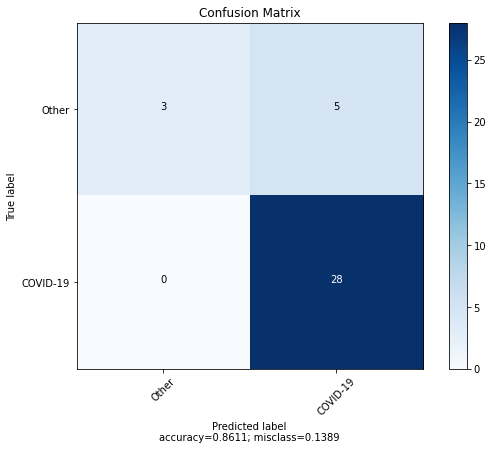

In [22]:
results = precision_recall_fscore_support(bin_labels, bin_preds, average='binary')
acc = accuracy_score(bin_labels, bin_preds)
roc_auc = roc_auc_score(bin_labels, bin_preds)

print("ROC_AUC: {}, Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(roc_auc, acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(bin_labels, bin_preds))
print("\n")
cnf_matrix = confusion_matrix(bin_labels, bin_preds)

plot_confusion_matrix(cm           = cnf_matrix, 
                      desc         = f"{best_model_idx+1}. FOLD - Binary",
                      normalize    = False,
                      target_names = ['Other','COVID-19'],
                      title        = "Confusion Matrix")

### Basic Speed Test on _NVIDIA_GTX_1070_

In [23]:
import time
for i in range(5): 
    img = cv2.imread(os.path.join(BASE_DIR,"images/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg"))
    x = cv2.resize(img, SHAPE[:2])
    x = np.divide(x, 255)
    x = x.reshape((1,) + x.shape) 
    start = time.time()
    prediction = best_model.predict(x, batch_size=1)
    finish = time.time()
    print(threshold_arr(prediction))
    print((finish-start)*1000,"ms")
    print("***")

[[0. 1. 0. 0. 0. 0.]]
213.03939819335938 ms
***
[[0. 1. 0. 0. 0. 0.]]
7.042169570922852 ms
***
[[0. 1. 0. 0. 0. 0.]]
7.9708099365234375 ms
***
[[0. 1. 0. 0. 0. 0.]]
8.000612258911133 ms
***
[[0. 1. 0. 0. 0. 0.]]
7.96055793762207 ms
***
